# Analysis

In [1]:
#basic tools and misc:
import time
import os
import gc
import itertools
import collections
import operator
import datetime
from tqdm import tqdm, trange

#data tools:
import pandas as pd
import numpy as np
from dask import array as da
from scipy.stats import pearsonr

#file handling:
import pickle
import json
import csv

#text tools
import morfeusz2 #polish language morphological analysis
import nltk
import re
from twitter_tools import tweet_stats, preprocess_tweets
from gensim.models import KeyedVectors

#visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
gov_data = pd.read_csv("data/clean/gov_tweets_clean.csv", header = 0, index_col = False, dtype = str, nrows = 1000)
gov_data["source"] = "government"

In [3]:
opp_data = pd.read_csv("data/clean/opp_tweets_clean.csv", header = 0, index_col = False, dtype = str, nrows = 1000)
opp_data["source"] = "opposition"

In [4]:
tweet_data = pd.concat([gov_data, opp_data], axis = 0)
del(gov_data)
del(opp_data)
gc.collect()

40

In [5]:
tweet_data = tweet_data.loc[tweet_data.created_at.notna()]

In [7]:
from stempel import StempelStemmer

Look at temporal distribution:

In [6]:
tweet_data = tweet_data.drop(columns = ["index"])

In [25]:
tweet_data["created_at"] = pd.to_datetime(tweet_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
tweet_data["month"] = tweet_data.created_at.dt.to_period("M")
tweet_data["day"] = tweet_data.created_at.dt.to_period("D")
tweet_data["hour"] = tweet_data.created_at.dt.to_period("H")

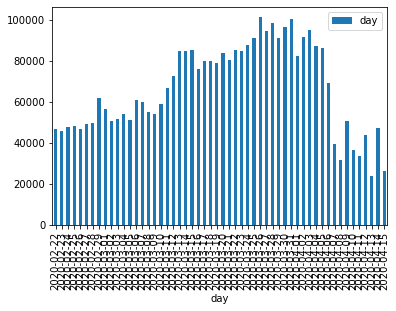

In [29]:
tweet_data.groupby("day")[["day"]].count().plot.bar()

Tokens frequency:

In [44]:
tweets_tokenized = map(lambda x: x.split(), tweet_data["preprocessed"].astype(str).tolist())
corpus = list(itertools.chain.from_iterable(tweets_tokenized))
bgs = nltk.bigrams(corpus)
#freq = nltk.FreqDist(bgs)
#freq.most_common(100)

In [46]:
freq = nltk.FreqDist(bgs)

In [47]:
freq.most_common(100)

[(('Pis', 'Pisa'), 146012),
 (('PiS', 'Pis'), 144801),
 (('wybory', 'wybór'), 129978),
 (('lato', 'rok'), 91804),
 (('musieć', 'musić'), 62843),
 (('mama', 'mamić'), 60850),
 (('maić', 'mieć'), 59386),
 (('lud', 'człowiek'), 58963),
 (('mieć', 'mama'), 57578),
 (('mieć', 'maja'), 52526),
 (('chybać', 'chyba'), 51123),
 (('mama', 'mieć'), 50963),
 (('niża', 'niżyć'), 48726),
 (('niżyć', 'nizać'), 48726),
 (('nan', 'nan'), 45313),
 (('polski', 'polskie'), 44513),
 (('dzienia', 'dzienie'), 43366),
 (('dzienie', 'dzienić'), 43366),
 (('dzień', 'dzienia'), 42558),
 (('życie', 'żyć'), 42463),
 (('nowy', 'nowa'), 41793),
 (('życie', 'żyto'), 35725),
 (('pytanie', 'pytać'), 35659),
 (('żyto', 'żyć'), 35471),
 (('głosowanie', 'głosować'), 33187),
 (('chory', 'chora'), 32502),
 (('mieć', 'miał'), 30403),
 (('tyli', 'tyle'), 28935),
 (('tyle', 'tył'), 28929),
 (('środki', 'środek'), 28903),
 (('media', 'medium'), 28536),
 (('działanie', 'działać'), 28197),
 (('muszy', 'musieć'), 28183),
 (('pierw

Popularity of words:

In [33]:
def word_popularity(word, tweets):
    return [tweet.count(word) for tweet in tweets]

In [60]:
def popularity_by_date(words, tweets, time):
    popularity = [word_popularity(word, tweets) for word in words]
    df = pd.DataFrame(np.column_stack(popularity), index = time)
    df.columns = words
    return df.groupby(df.index).sum()

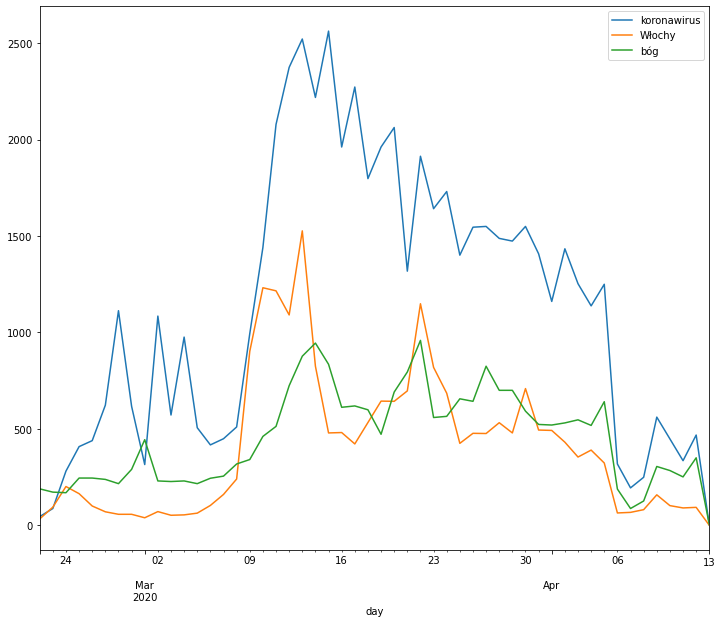

In [69]:
tweets_tokenized = map(lambda x: x.split(), tweet_data["preprocessed"].tolist())
pop = popularity_by_date(["koronawirus","Włochy","bóg"], list(tweets_tokenized), tweet_data["day"])
pop.plot(figsize = (12,10))
plt.show()

In [76]:
ind = np.where(data["day"] < pd.Period("04/06/2020"))[0].tolist()
twt = operator.itemgetter(*ind)(tweets_tokenized)
dat = data["day"].iloc[ind]
popularity_by_date(["koronawirus","prezydent","bóg"], twt, dat).corr()

Sentiment of each tweet:

In [76]:
sentiment_values = []
for tweet in tweets_tokenized:
    sentiment_values.append(np.mean([sentiment_5[word] for word in tweet]))

In [88]:
data["sentiment"] = pd.Series(sentiment_values)

Vectorization

In [ ]:
#Remove tweets with no content after preprocessing
tweets = [" ".join(tweet) for tweet in tweets_tokenized]
data["tweet_preprocessed"] = tweets
data = data[data["tweet_preprocessed"] != ""]
tweets = data["tweet_preprocessed"].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(np.array(tweets), data.source.tolist())

In [ ]:
Xtrain.shape

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(Xtrain)
Xtrain_tf = tfidf.transform(Xtrain)
Xtest_tf = tfidf.transform(Xtest)

In [ ]:
logit = LogisticRegression(max_iter = 1e5)
logit.fit(Xtrain_tf,Ytrain)

In [ ]:
ypred = logit.predict(Xtest_tf)

In [ ]:
confusion_matrix(Ytest,ypred)

In [ ]:
accuracy_score(Ytest,ypred)